<a href="https://colab.research.google.com/github/Hrithik2212/Generative-AI-and-LLMs-Course/blob/main/04_poem_generation_with_llms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poem Generation using FastAI


In [1]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 36.3 MB/s eta 0:00:00


In this tutorial you will see how to fine-tune a pretrained transformer model from the transformers library by HuggingFace. It can be very simple with FastAI's data loaders. It's possible to use any of the pretrained models from HuggingFace. Below we will experiment with GPT2.

## Import Libraries


In [2]:
# from fastbook import *
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

## Read Data
This data is organized by folder. There are two main folders: forms (e.g. haiku, sonnet, etc.) and topics (e.g. love, peace, etc.). Those main folders contain subfolders for the subcategories and then the poem txt files are contained in those.
With fastai, it's quite easy to read the data with the the get_text_files function. You can select all folders or select specific ones.

In [15]:
!mkdir ~/.kaggle
!cp /kaggle.json ~/.kaggle/
!kaggle datasets download -d michaelarman/poemsdataset

100% 15.5M/15.5M [00:01<00:00, 17.2MB/s]
100% 15.5M/15.5M [00:01<00:00, 9.46MB/s]


In [ ]:
!unzip /content/poemsdataset.zip

In [17]:
!mkdir /content/poemsdata
!mv /content/forms /content/poemsdata

In [18]:
!mv /content/topics /content/poemsdata

In [19]:
path = '/content/poemsdata'

In [20]:
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")

There are 20656 poems in the dataset


We'll start off with training the model on ballads. There are only 100 ballads so it won't take as long to train. However you can add more poem forms. For instance, a haiku would be very cool to experiment with and to see if it maintains the 5,7,5 syllable structure. You can also change the path to the topics folder instead of poem forms and you can try out a bunch of poem topics like love, anger, depression, etc..

In [21]:
ballads = get_text_files(path+'/forms', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 100 ballads in the dataset


In [22]:
txt = poems[0].open().read(); #read the first file
print(txt)

ll break into your thoughts
With what's written on my heart
I will break, break
I'm so sick,
Infected with where I live
Let me live without this
Empty bliss,
Selfishness
I'm so sick
I'm so sick
If you want more of this
We can push out, sell out, die out
So you'll shut up
And stay sleeping
With my screaming in your itching ears
I'm so sick,
Infected with where I live
Let me live without this
Empty bliss,
Selfishness
I'm so sick
I'm so sick
Hear it, I'm screaming it
You're heeding to it now
Hear it! I'm screaming it!
You tremble at this sound
You sink into my clothes
And this invasion
Makes me feel
Worthless, hopeless, sick
I'm so sick,
Infected with where I live
Let me live without this
Empty bliss,
Selfishness
I'm so sick
I'm so sick
I'm so sick
Infected with where I live
Let me live without this
Empty bliss, selfishness
I'm so
I'm so sick
I'm so
I'm so sick


## Prepare the Data



In [23]:
ballads = L(o.open().read() for o in ballads) # to make things easy we will gather all texts in one numpy array

In [24]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

all_ballads = flatten(ballads)

In [25]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [26]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [27]:
show_at(tls.train, 0)

I.
The death-bell beats!--
The mountain repeats
The echoing sound of the knell;
And the dark Monk now
Wraps the cowl round his brow,
As he sits in his lonely cell.
II.
And the cold hand of death
Chills his shuddering breath,
As he lists to the fearful lay
Which the ghosts of the sky,
As they sweep wildly by,
Sing to departed day.
And they sing of the hour
When the stern fates had power
To resolve Rosa’s form to its clay.
III.
But that hour is past;
And that hour was the last
Of peace to the dark Monk’s brain.
Bitter tears, from his eyes, gushed silent and fast;
And he strove to suppress them in vain.
IV.
Then his fair cross of gold he dashed on the floor,
When the death-knell struck on his ear.--
'Delight is in store
For her evermore;
But for me is fate, horror, and fear.'
V.
Then his eyes wildly rolled,
When the death-bell tolled,
And he raged in terrific woe.
And he stamped on the ground,--
But when ceased the sound,
Tears again began to flow.
VI.
And the ice of despair
Chilled the w

In [28]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors


In [29]:
dls.show_batch(max_n=2)

,text,text_
0,"translated by Will Kirkland\nThe moon came into the forge\nin her bustle of flowering nard.\nThe little boy stares at her, stares.\nThe boy is staring hard.\nIn the shaken air\nthe moon moves her amrs,\nand shows lubricious and pure,\nher breasts of hard tin.\n""Moon, moon, moon, run!\nIf the gypsies come,\nthey will use your heart\nto make white necklaces and rings.""\n""Let me dance, my little one.\nWhen the gypsies come,\nthey'll find you on the anvil\nwith your lively eyes closed tight.\n""Moon, moon, moon, run!\nI can feelheir horses come.""\n""Let me be, my little one,\ndon't step on me, all starched and white!""\nCloser comes the the horseman,\ndrumming on the plain.\nThe boy is in the forge;\nhis eyes are closed.\nThrough the olive grove\ncome the gypsies, dream and bronze,\ntheir heads held high,\ntheir hooded eyes.\nOh, how the night owl calls,\ncalling, calling from its tree!","lated by Will Kirkland\nThe moon came into the forge\nin her bustle of flowering nard.\nThe little boy stares at her, stares.\nThe boy is staring hard.\nIn the shaken air\nthe moon moves her amrs,\nand shows lubricious and pure,\nher breasts of hard tin.\n""Moon, moon, moon, run!\nIf the gypsies come,\nthey will use your heart\nto make white necklaces and rings.""\n""Let me dance, my little one.\nWhen the gypsies come,\nthey'll find you on the anvil\nwith your lively eyes closed tight.\n""Moon, moon, moon, run!\nI can feelheir horses come.""\n""Let me be, my little one,\ndon't step on me, all starched and white!""\nCloser comes the the horseman,\ndrumming on the plain.\nThe boy is in the forge;\nhis eyes are closed.\nThrough the olive grove\ncome the gypsies, dream and bronze,\ntheir heads held high,\ntheir hooded eyes.\nOh, how the night owl calls,\ncalling, calling from its tree!\n"
1,"\nWere Hepsy Higgins inclined to mate,\nOr Dorcas Eastman prone to invest\nIn Cupid's bonds, they could find their fate\nIn the bootless bard of Crockery Quest.\nFor they've heaps of trumpery--so have the rest\nOf those spinsters whose ware I'd like to own;\nYou can see why I say with such certain zest,\n""These do I love, and these alone.""Ye shepherds give ear to my lay,\nAnd take no more heed of my sheep:\nThey have nothing to do but to stray;\nI have nothing to do but to weep.\nYet do not my folly reprove;\nShe was fair -- and my passion begun;\nShe smil'd -- and I could not but love;\nShe is faithless -- and I am undone.\nPerhaps I was void of all thought:\nPerhaps it was plain to foresee,\nThat a nymph so compleat would be sought\nBy a swain more engaging than me.\nAh! love ev'ry hope can inspire;\nIt banishes wisdom the while;\nAnd the lip of the nymph we admire\nSeems for ever","Were Hepsy Higgins inclined to mate,\nOr Dorcas Eastman prone to invest\nIn Cupid's bonds, they could find their fate\nIn the bootless bard of Crockery Quest.\nFor they've heaps of trumpery--so have the rest\nOf those spinsters whose ware I'd like to own;\nYou can see why I say with such certain zest,\n""These do I love, and these alone.""Ye shepherds give ear to my lay,\nAnd take no more heed of my sheep:\nThey have nothing to do but to stray;\nI have nothing to do but to weep.\nYet do not my folly reprove;\nShe was fair -- and my passion begun;\nShe smil'd -- and I could not but love;\nShe is faithless -- and I am undone.\nPerhaps I was void of all thought:\nPerhaps it was plain to foresee,\nThat a nymph so compleat would be sought\nBy a swain more engaging than me.\nAh! love ev'ry hope can inspire;\nIt banishes wisdom the while;\nAnd the lip of the nymph we admire\nSeems for ever"


## Fine-tuning the model

In [30]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [31]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [32]:
learn.validate()

(#2) [4.179684638977051,65.34524536132812]

SuggestedLRs(valley=0.00015848931798245758)

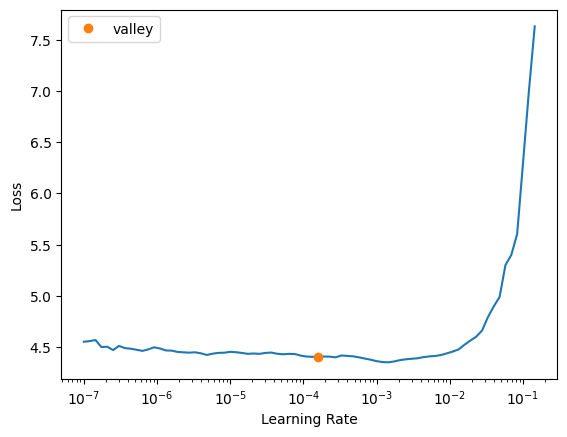

In [33]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.309217,3.995281,54.341122,00:45


## Poem Generation Example

In [35]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 3])

Adding the `num_beams` and `no_repeat_ngram_size` arguments make a huge difference. This can be explained [here](https://huggingface.co/blog/how-to-generate). Basically beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Without beam search you will obtain a more greedy search. Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output. Moreover, without the `no_repeat_ngram_size` you will likely obtain a repeated output. Thus we add a penalty that makes sure that no n-gram appears twice by manually setting the probability of next words that could create an already seen n-gram to 0.

In [36]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous.
And I am not a man of the world,
I am a woman of a world.


But I know that I cannot live, and I do not know how to live;
For I have not the strength to fight, nor the courage to die;




In [37]:
prompt = "I don't know what I would do"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I don't know what I would do with my life."
"I'm sure you'd like to see me dead, but I'm afraid I'll never see you again. I've never seen a man so beautiful as you. Don't you think I'd be happy to be dead?"

